# Data Loading and Preprocessing

In [28]:
from google.colab import drive

In [33]:
drive.mount('/drive')

Mounted at /drive


In [46]:
import pandas as pd
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2022-06-21 17:41:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-21 17:41:45 (94.8 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [69]:
yelp_data = pd.read_csv('/drive/MyDrive/NLP Datasets/yelp_ratings.csv')

In [70]:
yelp_data.shape

(44530, 3)

In [71]:
yelp_data.head(15)

,text,stars,sentiment
0,Total bill for this horrible service? Over $8G...,1.0,0
1,I *adore* Travis at the Hard Rock's new Kelly ...,5.0,1
2,I have to say that this office really has it t...,5.0,1
3,Went in for a lunch. Steak sandwich was delici...,5.0,1
4,Today was my second out of three sessions I ha...,1.0,0
5,I'll be the first to admit that I was not exci...,4.0,1
6,This place has gone down hill. Clearly they h...,1.0,0
7,I was really looking forward to visiting after...,2.0,0
8,"Like walking back in time, every Saturday morn...",4.0,1
9,"Walked in around 4 on a Friday afternoon, we s...",1.0,0


In [72]:
# How many examples of each class?
yelp_data.sentiment.value_counts()

1    33331
0    11199
Name: sentiment, dtype: int64

In [73]:
yelp_data.drop("stars", axis=1, inplace=True)

In [82]:
yelp_data.head(5)

,text,sentiment
0,Total bill for this horrible service? Over $8G...,0
1,I *adore* Travis at the Hard Rock's new Kelly ...,1
2,I have to say that this office really has it t...,1
3,Went in for a lunch. Steak sandwich was delici...,1
4,Today was my second out of three sessions I ha...,0


In [75]:
# Shuffle training dataframe
train_df_shuffled = yelp_data.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.shape, train_df_shuffled.head(5)

((44530, 2),
                                                     text  sentiment
 10092  This review is for Wynn Fitness Richmond Hill,...          1
 26633  Great little dive with cheap drinks. The Burge...          1
 29324  The pho it's self isn't bad at all, very littl...          0
 15822  I love going there when I want to host a nice ...          1
 6631   I ordered and after 40 minutes I get a text th...          0)

In [78]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(yelp_data)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "sentiment"]][random_index:random_index+5].itertuples():
  _, text, sentiment = row
  print(f"Target: {sentiment}", "(positive review)" if sentiment > 0 else "(negative review)")
  print(f"Text: {text}\n")
  print("---\n")

Target: 0 (negative review)
Text: They deserve ZERO STARS but Yelp doesn't offer that option. I've used this car wash several times out of convenience,  however the service and quality of work is always the same...TERRIBLE!  Even when you call them out on the lack of effort, their none contributing to society, waste of space employees still do a s@#ty. 

If I'm not clear, I'm saying YOU SUCK FULL CIRCLE...

---

Target: 0 (negative review)
Text: I have my own Nonna so when I found out that this place was run by old-school Italians I was overjoyed.  My experience with them, after many visits, is that despite their kind demeanour the food is nothing like home cooking.  The sauce is so heavy on the oregano and tinned tomato concentrate and it tastes as if they add sugar to reduce the acidity - very mangiacake. Because the sauce is so poor, their sandwiches taste like the ones you get Pizza Pizza.  Their chicken parmigianna is cafeteria-level.  Pepperoni pizza features pepperoni straight f

In [79]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(yelp_data["text"].to_numpy(),
                                                                            yelp_data["sentiment"].to_numpy(),
                                                                            test_size=0.2, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [80]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(35624, 35624, 8906, 8906)

In [81]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['Great vegan options! The food is always fresh and prepared well. It can be a little crowded but the atmosphere is fun. One of my favorite places!',
        'Hands down the best sushi place of town of markham. Hidden gem. This place has the greatest service. And the chef and the people that work here are always happy. The sushi portions are huge and delicious.',
        "Great food, but please don't lock your doors at 7:40 when you advertise being open until 8pm. I made a special trip for JJ's only to be met with a locked door and no notice of the change or practice.  Disappointing.  I'll definitely think twice next time I want a hot dog.",
        'Came here today for lunch ordered the chicken cho fun . My friend has the island chicken and we tried the spring rolls. Best sweet and sour sauce I have ever had and we got our food within minutes!',
        "Overall so delicious! Housemade chips are perfection. The guacamole is good, though definitely has crema mixed in, which I'd 

# Text vectorization (tokenization)

In [91]:
import tensorflow as tf

# Use the default TextVectorization variables
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                                    standardize="lower_and_strip_punctuation", # how to process text
                                                    split="whitespace", # how to split tokens
                                                    ngrams=None, # create groups of n-words?
                                                    output_mode="int", # how to map tokens to numbers
                                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [88]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

106

**Now let's create another TextVectorization object using our custom parameters.**

In [94]:
from tensorflow.keras.layers import TextVectorization

# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [95]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [96]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 441,    5, 8786,   12,   13,  565,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [97]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
I highly recommend this law office. Krissy took on my case and took care of it as fast as possible I didn't think I would get my settlement so fast. My accident happened oct. 2016 and received my settlement feb. 2018. She did a great job kept me well updated.      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   4,  245,  124,   16, 2644,  466,    1,  149,   20,   13,  849,
           3,  149,  249,    8]])>

In [98]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'and', 'i']
Bottom 5 least common words: ['jpg', 'jonathan', 'jess', 'jenni', 'jasons']


# Embedding Layer

In [100]:
tf.random.set_seed(42)
from tensorflow.keras.layers import Embedding

embedding = Embedding(input_dim=max_vocab_length, # set input shape
                      output_dim=128, # set size of embedding vector
                      embeddings_initializer="uniform", # default, intialize randomly
                      input_length=max_length, # how long is each input
                      name="embedding_1") 

embedding

In [101]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Such a great place to have a good time. Anarbol Martinez totally hooked us up with a bay towards the center on the third floor on a Saturday night where the wait was set to 45 minutes to get a spot on either the third or second floor. Now that's what I call customer service! He's the best!      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02770803, -0.02877747,  0.02347932, ...,  0.03209184,
         -0.02208823, -0.00824679],
        [-0.03521683, -0.00981399, -0.00284491, ..., -0.04792733,
         -0.01664252, -0.03293632],
        [ 0.04049121, -0.00741907, -0.00506904, ...,  0.02288493,
          0.03335415, -0.04155653],
        ...,
        [-0.02300658,  0.02515138,  0.00135379, ...,  0.02369482,
          0.02020344, -0.04502844],
        [-0.0282429 , -0.01332953, -0.03716351, ..., -0.04596538,
         -0.02836199, -0.0376353 ],
        [-0.01456394,  0.02664156, -0.0070488 , ...,  0.00958163,
         -0.01225308,  0.04130488]]], dtype=float32)>

In [102]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.02770803, -0.02877747,  0.02347932, -0.04396946,  0.03285495,
        0.03839954,  0.00806413,  0.02695229,  0.02802075,  0.00113881,
        0.0133984 ,  0.04699519,  0.00237359, -0.04237021, -0.02363363,
        0.03466617,  0.01312608, -0.0404911 ,  0.03504953, -0.00654498,
       -0.02442173,  0.02995959, -0.00733645,  0.00400343, -0.04402372,
        0.04039264, -0.01737512,  0.04454163,  0.0497917 , -0.01291456,
        0.00721056, -0.00984938, -0.00345488, -0.04044552,  0.03783008,
        0.00393597, -0.04253433,  0.0472242 ,  0.03149721, -0.02542652,
       -0.02119037,  0.02701832,  0.01857468,  0.0063289 ,  0.0338707 ,
       -0.03576756,  0.02940394, -0.01099084, -0.04248435, -0.03011486,
        0.03905234, -0.02212126, -0.04244724,  0.04546647,  0.03012883,
        0.01994801, -0.00195368,  0.02574405, -0.02841196, -0.02761663,
        0.01776842, -0.04653288,  0.02052915,  0.02659552, -0.03576815,
       -0.048521

# Baseline Model : Naive Bayes

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [104]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 80.93%


In [105]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [106]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [107]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 80.93420166180103,
 'f1': 0.7640829488032853,
 'precision': 0.8451710651494836,
 'recall': 0.8093420166180103}

# Model 1: A simple dense model

In [108]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [109]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [110]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_7 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [111]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
1114/1114 [==============================] - 11s 6ms/step - loss: 0.4306 - accuracy: 0.8008 - val_loss: 0.3668 - val_accuracy: 0.8402
Epoch 2/5
1114/1114 [==============================] - 6s 5ms/step - loss: 0.3220 - accuracy: 0.8580 - val_loss: 0.3597 - val_accuracy: 0.8420
Epoch 3/5
1114/1114 [==============================] - 6s 6ms/step - loss: 0.2923 - accuracy: 0.8724 - val_loss: 0.3704 - val_accuracy: 0.8401
Epoch 4/5
1114/1114 [==============================] - 7s 6ms/step - loss: 0.2754 - accuracy: 0.8794 - val_loss: 0.3795 - val_accuracy: 0.8356
Epoch 5/5
1114/1114 [==============================] - 7s 6ms/step - loss: 0.2636 - accuracy: 0.8858 - val_loss: 0.3942 - val_accuracy: 0.8298


In [112]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

279/279 [==============================] - 1s 5ms/step - loss: 0.3942 - accuracy: 0.8298


[0.3941967785358429, 0.8297776579856873]

In [113]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.03871234, -0.03869727,  0.00189553, ...,  0.01281819,
          0.02555337, -0.0170142 ],
        [ 0.06090167, -0.06761583, -0.01314532, ...,  0.03087384,
          0.05670063,  0.005737  ],
        [ 0.02220308,  0.02258053,  0.01841767, ..., -0.04997643,
         -0.02554815, -0.00498999],
        ...,
        [-0.11944845,  0.07933617, -0.13057937, ..., -0.06191379,
         -0.08575214,  0.11046026],
        [ 0.20128457, -0.13633358,  0.16596237, ...,  0.13481452,
          0.17523207, -0.15257417],
        [ 0.11786641, -0.0924459 ,  0.07385511, ...,  0.1336745 ,
          0.06079776, -0.13301806]], dtype=float32)>]

In [114]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [115]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

array([[0.19590467],
       [0.99705184],
       [0.85215014],
       [0.93634665],
       [0.36855054],
       [0.02222292],
       [0.81128335],
       [0.65268654],
       [0.20201305],
       [0.99990153]], dtype=float32)

In [116]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       1., 0., 1.], dtype=float32)>

In [117]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 82.9777677969908,
 'f1': 0.8257380880996882,
 'precision': 0.8238985494546599,
 'recall': 0.829777677969908}

In [118]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([ True, False,  True,  True])

In [119]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 80.93, New accuracy: 82.98, Difference: 2.04
Baseline precision: 0.85, New precision: 0.82, Difference: -0.02
Baseline recall: 0.81, New recall: 0.83, Difference: 0.02
Baseline f1: 0.76, New f1: 0.83, Difference: 0.06


# Model 2: LSTM (Recurrent Neural Networks)

In [122]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [123]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [124]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_7 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [125]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
1114/1114 [==============================] - 14s 8ms/step - loss: 0.3870 - accuracy: 0.8241 - val_loss: 0.3651 - val_accuracy: 0.8410
Epoch 2/5
1114/1114 [==============================] - 12s 11ms/step - loss: 0.2961 - accuracy: 0.8699 - val_loss: 0.3535 - val_accuracy: 0.8442
Epoch 3/5
1114/1114 [==============================] - 12s 11ms/step - loss: 0.2438 - accuracy: 0.8930 - val_loss: 0.3857 - val_accuracy: 0.8433
Epoch 4/5
1114/1114 [==============================] - 9s 8ms/step - loss: 0.1997 - accuracy: 0.9121 - val_loss: 0.4225 - val_accuracy: 0.8322
Epoch 5/5
1114/1114 [==============================] - 8s 7ms/step - loss: 0.1651 - accuracy: 0.9294 - val_loss: 0.4719 - val_accuracy: 0.8235


In [126]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

((8906, 1), array([[0.0083376 ],
        [0.9984315 ],
        [0.11761797],
        [0.9828569 ],
        [0.54734457],
        [0.00214383],
        [0.5672105 ],
        [0.7659084 ],
        [0.3843625 ],
        [0.99902236]], dtype=float32))

In [127]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 0., 1., 1., 0., 1., 1., 0., 1.], dtype=float32)>

In [128]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 82.3489782169324,
 'f1': 0.8229453321651362,
 'precision': 0.8224428631465093,
 'recall': 0.823489782169324}

In [129]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 80.93, New accuracy: 82.35, Difference: 1.41
Baseline precision: 0.85, New precision: 0.82, Difference: -0.02
Baseline recall: 0.81, New recall: 0.82, Difference: 0.01
Baseline f1: 0.76, New f1: 0.82, Difference: 0.06


# Model 3: Gated Recurrent Unit

In [130]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [131]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [132]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_7 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [133]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
1114/1114 [==============================] - 11s 7ms/step - loss: 0.3949 - accuracy: 0.8197 - val_loss: 0.3628 - val_accuracy: 0.8427
Epoch 2/5
1114/1114 [==============================] - 8s 7ms/step - loss: 0.2959 - accuracy: 0.8701 - val_loss: 0.3452 - val_accuracy: 0.8482
Epoch 3/5
1114/1114 [==============================] - 8s 7ms/step - loss: 0.2369 - accuracy: 0.8992 - val_loss: 0.3754 - val_accuracy: 0.8430
Epoch 4/5
1114/1114 [==============================] - 11s 10ms/step - loss: 0.1891 - accuracy: 0.9199 - val_loss: 0.4185 - val_accuracy: 0.8310
Epoch 5/5
1114/1114 [==============================] - 12s 11ms/step - loss: 0.1536 - accuracy: 0.9373 - val_loss: 0.4779 - val_accuracy: 0.8257


In [134]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((8906, 1), array([[0.01607343],
        [0.99815685],
        [0.8978066 ],
        [0.94265634],
        [0.65459615],
        [0.00169773],
        [0.84178245],
        [0.43072248],
        [0.28488135],
        [0.9993197 ]], dtype=float32))

In [135]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 1., 1., 0., 1., 0., 0., 1.], dtype=float32)>

In [136]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 82.57354592409611,
 'f1': 0.8252757579479831,
 'precision': 0.8248470266963576,
 'recall': 0.8257354592409611}

In [137]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 80.93, New accuracy: 82.57, Difference: 1.64
Baseline precision: 0.85, New precision: 0.82, Difference: -0.02
Baseline recall: 0.81, New recall: 0.83, Difference: 0.02
Baseline f1: 0.76, New f1: 0.83, Difference: 0.06


# Model 4: Bidirectonal RNN model



A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

Once again, TensorFlow helps us out by providing the tensorflow.keras.layers.Bidirectional class. We can use the Bidirectional class to wrap our existing RNNs, instantly making them bidirectional.

In [138]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [139]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [140]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_7 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3


Notice the increased number of trainable parameters in model_4 (bidirectional LSTM) compared to model_2 (regular LSTM). This is due to the bidirectionality we added to our RNN.

Time to fit our bidirectional model and track its performance.

In [141]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
1114/1114 [==============================] - 19s 13ms/step - loss: 0.3846 - accuracy: 0.8243 - val_loss: 0.3493 - val_accuracy: 0.8434
Epoch 2/5
1114/1114 [==============================] - 13s 12ms/step - loss: 0.2924 - accuracy: 0.8711 - val_loss: 0.3454 - val_accuracy: 0.8474
Epoch 3/5
1114/1114 [==============================] - 17s 16ms/step - loss: 0.2369 - accuracy: 0.8966 - val_loss: 0.3669 - val_accuracy: 0.8467
Epoch 4/5
1114/1114 [==============================] - 10s 9ms/step - loss: 0.1848 - accuracy: 0.9204 - val_loss: 0.4284 - val_accuracy: 0.8345
Epoch 5/5
1114/1114 [==============================] - 10s 9ms/step - loss: 0.1422 - accuracy: 0.9410 - val_loss: 0.5250 - val_accuracy: 0.8230


In [142]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[9.7836123e-04],
       [9.9997580e-01],
       [6.3112094e-03],
       [9.1654748e-01],
       [5.8983284e-01],
       [2.9171905e-03],
       [9.8176378e-01],
       [8.7566227e-01],
       [1.2875442e-01],
       [9.9954671e-01]], dtype=float32)

In [143]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 0., 1., 1., 0., 1., 1., 0., 1.], dtype=float32)>

In [144]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 82.30406467549966,
 'f1': 0.8236438126450155,
 'precision': 0.8243008916729723,
 'recall': 0.8230406467549967}

In [145]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 80.93, New accuracy: 82.30, Difference: 1.37
Baseline precision: 0.85, New precision: 0.82, Difference: -0.02
Baseline recall: 0.81, New recall: 0.82, Difference: 0.01
Baseline f1: 0.76, New f1: 0.82, Difference: 0.06


# Convolutional Neural Networks for Text

You might've used convolutional neural networks (CNNs) for images before but they can also be used for sequences.

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, we use a 1-dimensional convolution instead of a 2-dimensional convolution.

A typical CNN architecture for sequences will look like the following:

Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)

# Model 5: Conv1D

Before we build a full 1-dimensional CNN model, let's see a 1-dimensional convolutional layer (also called a temporal convolution) in action.

We'll first create an embedding of a sample of text and experiment passing it through a Conv1D() layer and GlobalMaxPool1D() layer.

In [146]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

Notice the output shapes of each layer.

The embedding has an output shape dimension of the parameters we set it to (input_length=15 and output_dim=128).

The 1-dimensional convolutional layer has an output which has been compressed inline with its parameters. And the same goes for the max pooling layer output.

Our text starts out as a string but gets converted to a feature vector of length 64 through various transformation steps (from tokenization to embedding to 1-dimensional convolution to max pool).

Let's take a peak at what each of these transformations looks like.

In [147]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.01599608, -0.03830674,  0.01893974, ...,  0.02351819,
           0.04738515, -0.02535202],
         [-0.03182955,  0.02554603,  0.01298493, ...,  0.05565028,
          -0.01292515,  0.05094353],
         [-0.01704365, -0.04015286,  0.015127  , ..., -0.02315823,
           0.00169129, -0.05018114],
         ...,
         [ 0.03871234, -0.03869727,  0.00189553, ...,  0.01281819,
           0.02555337, -0.0170142 ],
         [ 0.03871234, -0.03869727,  0.00189553, ...,  0.01281819,
           0.02555337, -0.0170142 ],
         [ 0.03871234, -0.03869727,  0.00189553, ...,  0.01281819,
           0.02555337, -0.0170142 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.0215404 , 0.11294822, 0.04790434, 0.01488059, 0.        ,
          0.        , 0.        , 0.02871225, 0.0299211 , 0.05193426,
          0.        , 0.03357544, 0.04766515, 0.        , 0.        ,
          0.        , 0.

In [148]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_7 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [149]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
1114/1114 [==============================] - 11s 8ms/step - loss: 0.4037 - accuracy: 0.8134 - val_loss: 0.3607 - val_accuracy: 0.8376
Epoch 2/5
1114/1114 [==============================] - 13s 12ms/step - loss: 0.2850 - accuracy: 0.8786 - val_loss: 0.3680 - val_accuracy: 0.8382
Epoch 3/5
1114/1114 [==============================] - 7s 6ms/step - loss: 0.2008 - accuracy: 0.9208 - val_loss: 0.4152 - val_accuracy: 0.8338
Epoch 4/5
1114/1114 [==============================] - 7s 6ms/step - loss: 0.1256 - accuracy: 0.9544 - val_loss: 0.4838 - val_accuracy: 0.8285
Epoch 5/5
1114/1114 [==============================] - 10s 9ms/step - loss: 0.0682 - accuracy: 0.9786 - val_loss: 0.5803 - val_accuracy: 0.8230


In [150]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[1.2827311e-02],
       [9.9944323e-01],
       [7.5288302e-01],
       [9.9980992e-01],
       [5.1950112e-02],
       [4.9207538e-06],
       [9.8747545e-01],
       [9.9685943e-01],
       [2.8002808e-02],
       [9.9999988e-01]], dtype=float32)

In [151]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 1., 0., 0., 1., 1., 0., 1.], dtype=float32)>

In [152]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 82.30406467549966,
 'f1': 0.8208673618194506,
 'precision': 0.8193165950649353,
 'recall': 0.8230406467549967}

# Using Pretrained Embeddings (transfer learning for NLP)

For all of the previous deep learning models we've built and trained, we've created and used our own embeddings from scratch each time.

However, a common practice is to leverage pretrained embeddings through transfer learning. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

For our next model, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.

More specifically, we're going to be using the Universal Sentence Encoder from TensorFlow Hub (a great resource containing a plethora of pretrained model resources for a variety of tasks).

🔑 Note: There are many different pretrained text embedding options on TensorFlow Hub, however, some require different levels of text preprocessing than others. Best to experiment with a few and see which best suits your use case.

# Model 6: TensorFlow Hub Pretrained Sentence Encoder

The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, as you might've guessed, creates a whole sentence-level embedding.

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

The feature extractor model we're building through the eyes of an encoder/decoder model.

🔑 Note: An encoder is the name for a model which converts raw data such as text into a numerical representation (feature vector), a decoder converts the numerical representation to a desired output.

As usual, this is best demonstrated with an example.

We can load in a TensorFlow Hub module using the hub.load() method and passing it the target URL of the module we'd like to use, in our case, it's "https://tfhub.dev/google/universal-sentence-encoder/4".

Let's load the Universal Sentence Encoder model and test it on a couple of sentences.

In [153]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [154]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [155]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [156]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [157]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
1114/1114 [==============================] - 46s 38ms/step - loss: 0.1887 - accuracy: 0.9263 - val_loss: 0.1571 - val_accuracy: 0.9379
Epoch 2/5
1114/1114 [==============================] - 34s 31ms/step - loss: 0.1448 - accuracy: 0.9422 - val_loss: 0.1561 - val_accuracy: 0.9386
Epoch 3/5
1114/1114 [==============================] - 35s 32ms/step - loss: 0.1416 - accuracy: 0.9432 - val_loss: 0.1622 - val_accuracy: 0.9370
Epoch 4/5
1114/1114 [==============================] - 37s 33ms/step - loss: 0.1385 - accuracy: 0.9450 - val_loss: 0.1537 - val_accuracy: 0.9400
Epoch 5/5
1114/1114 [==============================] - 36s 32ms/step - loss: 0.1350 - accuracy: 0.9464 - val_loss: 0.1495 - val_accuracy: 0.9411


In [158]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.9851863 ],
       [0.99902916],
       [0.05330412],
       [0.9998419 ],
       [0.05279095],
       [0.01278452],
       [0.4422611 ],
       [0.00419876],
       [0.9992336 ],
       [0.9933948 ]], dtype=float32)

In [159]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 0., 1., 0., 0., 0., 0., 1., 1.], dtype=float32)>

In [160]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 94.10509768695262,
 'f1': 0.9411313779122601,
 'precision': 0.9412225474565296,
 'recall': 0.9410509768695262}

In [161]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 80.93, New accuracy: 94.11, Difference: 13.17
Baseline precision: 0.85, New precision: 0.94, Difference: 0.10
Baseline recall: 0.81, New recall: 0.94, Difference: 0.13
Baseline f1: 0.76, New f1: 0.94, Difference: 0.18


# Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

In [162]:
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [163]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 35624
Length of 10% training examples: 3563


In [164]:
# Check the number of targets in our subset of data 
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

1    2647
0     916
dtype: int64

In [165]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [166]:

# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
112/112 [==============================] - 14s 93ms/step - loss: 0.4280 - accuracy: 0.8075 - val_loss: 0.2743 - val_accuracy: 0.9096
Epoch 2/5
112/112 [==============================] - 14s 124ms/step - loss: 0.2225 - accuracy: 0.9214 - val_loss: 0.1957 - val_accuracy: 0.9256
Epoch 3/5
112/112 [==============================] - 9s 82ms/step - loss: 0.1771 - accuracy: 0.9310 - val_loss: 0.1768 - val_accuracy: 0.9287
Epoch 4/5
112/112 [==============================] - 14s 127ms/step - loss: 0.1605 - accuracy: 0.9380 - val_loss: 0.1716 - val_accuracy: 0.9302
Epoch 5/5
112/112 [==============================] - 11s 96ms/step - loss: 0.1527 - accuracy: 0.9377 - val_loss: 0.1683 - val_accuracy: 0.9321


In [167]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.9781516 ],
       [0.9982395 ],
       [0.21154617],
       [0.9997949 ],
       [0.12941796],
       [0.01107778],
       [0.32089096],
       [0.01436467],
       [0.9959403 ],
       [0.9913852 ]], dtype=float32)

In [168]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 0., 1., 0., 0., 0., 0., 1., 1.], dtype=float32)>

In [169]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 93.20682685829777,
 'f1': 0.9312835604405011,
 'precision': 0.9311992435306915,
 'recall': 0.9320682685829778}

In [170]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 80.93, New accuracy: 93.21, Difference: 12.27
Baseline precision: 0.85, New precision: 0.93, Difference: 0.09
Baseline recall: 0.81, New recall: 0.93, Difference: 0.12
Baseline f1: 0.76, New f1: 0.93, Difference: 0.17


# Comparing the performance of each of our models

In [171]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,80.934202,0.845171,0.809342,0.764083
simple_dense,82.977768,0.823899,0.829778,0.825738
lstm,82.348978,0.822443,0.823490,0.822945
gru,82.573546,0.824847,0.825735,0.825276
bidirectional,82.304065,0.824301,0.823041,0.823644
conv1d,82.304065,0.819317,0.823041,0.820867
tf_hub_sentence_encoder,94.105098,0.941223,0.941051,0.941131
tf_hub_10_percent_data,93.206827,0.931199,0.932068,0.931284


In [172]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

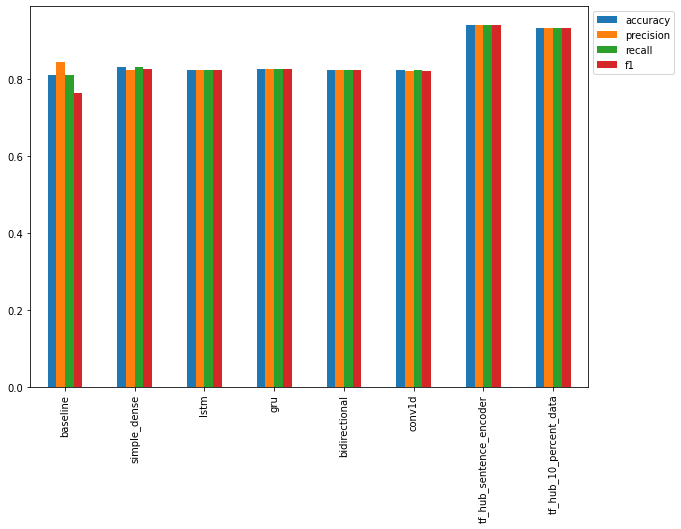

In [173]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

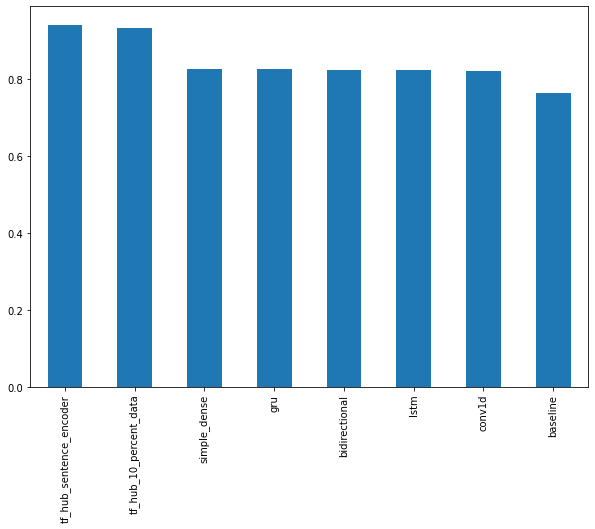

In [174]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Ensemble Model : Combining our models (model stacking)

In [175]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       1., 0., 1.], dtype=float32)>

In [176]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 90.8713227037952,
 'f1': 0.9035534154355931,
 'precision': 0.9114993301264417,
 'recall': 0.908713227037952}

In [177]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [179]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [181]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.809342,0.845171,0.809342,0.764083
simple_dense,0.829778,0.823899,0.829778,0.825738
lstm,0.823490,0.822443,0.823490,0.822945
gru,0.825735,0.824847,0.825735,0.825276
bidirectional,0.823041,0.824301,0.823041,0.823644
conv1d,0.823041,0.819317,0.823041,0.820867
tf_hub_sentence_encoder,0.941051,0.941223,0.941051,0.941131
tf_hub_10_percent_data,0.932068,0.931199,0.932068,0.931284
ensemble_results,0.009087,0.911499,0.908713,0.903553


# Saving and loading a trained model

Although training time didn't take very long, it's good practice to save your trained models to avoid having to retrain them.

Saving your models also enables you to export them for use elsewhere outside of your notebooks, such as in a web application.

There are two main ways of saving a model in TensorFlow:

The HDF5 format.
The SavedModel format (default).
Let's take a look at both.



In [182]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [183]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [186]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

279/279 [==============================] - 10s 37ms/step - loss: 0.1495 - accuracy: 0.9411


[0.1495366096496582, 0.9410510063171387]

In [185]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [187]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [188]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

279/279 [==============================] - 9s 30ms/step - loss: 0.1495 - accuracy: 0.9411


[0.149536594748497, 0.9410510063171387]

As you can see saving and loading our model with either format results in the same performance.

🤔 Question: Should you used the SavedModel format or HDF5 format?

For most use cases, the SavedModel format will suffice. However, this is a TensorFlow specific standard. If you need a more general-purpose data standard, HDF5 might be better.

# Finding the most wrong examples

In [189]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,"This review is for Wynn Fitness Richmond Hill,...",1,1.0,0.985186
1,Great little dive with cheap drinks. The Burge...,1,1.0,0.999029
2,"The pho it's self isn't bad at all, very littl...",0,0.0,0.053304
3,I love going there when I want to host a nice ...,1,1.0,0.999842
4,I ordered and after 40 minutes I get a text th...,0,0.0,0.052791


In [190]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
1907,Used to be good 10 years ago until recently (2...,0,1.0,0.998809
687,Good wings. But be prepared to pay extra for r...,0,1.0,0.997459
4465,Coffee cake is always good. I usually order my...,0,1.0,0.996993
4971,Update 4/11/13-- Since they have opened their ...,0,1.0,0.996796
7847,"Generic menu (salads, burgers, and steak). Hig...",0,1.0,0.994691
336,I do love me some Dairy Queen but this particu...,0,1.0,0.990768
1665,Update:\nThis used to be my fav Thai place but...,0,1.0,0.990643
2233,I came in for a couples massage for my birthda...,0,1.0,0.990457
3664,Free cookie if you check in with yelp! YES pl...,0,1.0,0.990412
6064,J'adore la cuisine indienne; c'est probablemen...,0,1.0,0.984982


In [191]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text: {text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9988094568252563
Text: Used to be good 10 years ago until recently (2013-present) frequent visits all left us with the same souvenir, tummy-aches after we got home.

Lots of Chinese celebrations here for mid-summer autumn and the new year. Is always booked for parties. 

Large selection of food and drinks. Decorated western-styled. Parking is a breeze.

----

Target: 0, Pred: 1, Prob: 0.9974588751792908
Text: Good wings. But be prepared to pay extra for ranch celery...really anything sloppy ex sauce.anything custom. Service..ok. Close early so not a place to chill after like 1030. And owners are always hovering over the bartenders so if you have more than a couple drinks you will be cut off. Good points....it's clean. Food is good. Andre is awesome.  Tonya is amazing to her customers.

----

Target: 0, Pred: 1, Prob: 0.996992826461792
Text: Coffee cake is always good. I usually order my usual, country fried chicken steak and eggs with gravy...:) Vegas doesn'

In [192]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.020968636497855186
Text:
I had the tropical crepes and my husband had the country skillet. The food was good. The coffee was fresh and hot, and they have flavored creamers. The service was a little slow, but not horrible. I was surprised that it wasn't packed on a Sunday at noon. My biggest complaint was that it was really really hot in there. Like, profusely sweating. We thought it may be because we were seated by a window, but I asked other patrons sitting across the restaurant and they were just as hot as us. I'd almost drop it to 3 stars because of that, but I'm willing to give them one more chance because the food was good.

----

Target: 1, Pred: 0, Prob: 0.02077692374587059
Text:
I am leaving feedback today because of the previous reviews I read. I have been going here on and off for the past 5-6 years.  I have sprayed tan which the dark isn't really dark and it didn't last long (maybe my skin oils?) so I was having to come back every 2 days so I swit

# Predictions on custom data

In [204]:
review_1 = "Horrible taste, wish I hadn't wasted my money here"
review_2 = "Seems great, would definitely check out later."
review_3 = "The taste was just ok, not bad,not good."
review_4 = "Pie was amazing but beef didn't seem fresh, 6/10 in my opinion."
review_5 = "Food tasted good but the service was disgusting, waiters were late and the food wasn't served in time."
review_6 = "Service was neutral but the food was fresh, hot and tasty."

In [216]:
pred_prob = tf.squeeze(model_6.predict([review_1])) # has to be list
pred = tf.round(pred_prob)
print(f"Pred: {int(pred)}, Prob: {pred_prob}")

Pred: 0, Prob: 0.0009475264232605696


In [229]:
def pred_and_prob_sentence(sentence):
    pred_prob = tf.squeeze(model_6.predict([sentence])) # has to be list
    pred = tf.round(pred_prob)
    print(f"Pred: {int(pred)}", "(positive review)" if pred > 0 else "(negative review)", f", Prob: {pred_prob}")

In [228]:
pred_and_prob_sentence(review_2)

Pred: 1 (positive review) , Prob: 0.9983795881271362


In [230]:
pred_and_prob_sentence(review_3)

Pred: 0 (negative review) , Prob: 0.034002117812633514


In [231]:
pred_and_prob_sentence(review_4)

Pred: 0 (negative review) , Prob: 0.347427636384964


In [232]:
pred_and_prob_sentence(review_5)

Pred: 0 (negative review) , Prob: 0.008545465767383575


In [233]:
pred_and_prob_sentence(review_6)

Pred: 1 (positive review) , Prob: 0.5346159338951111
